## Dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import tensorflow as tf
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import time
import datetime

## Loading the Data

In [3]:
folder = '../input/g-research-crypto-forecasting/'

# Train data
base_train = pd.read_csv(folder+'train.csv', low_memory=False)

# Assets
asset_mapping = pd.read_csv(folder+'asset_details.csv')
asset_mapping

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Preprocessing Data

In [4]:
# converting the timestamp to minutes
base_train['time'] = pd.to_datetime(base_train['timestamp'], unit='s')
base_train.head(50)

base_train.isnull().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
time              0
dtype: int64

In [5]:
print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))
    
btc = base_train.loc[base_train['Asset_ID'] == 1]
btc.set_index(btc.time, drop=True, inplace=True)

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0


2021-11-22 22:46:05.223252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 22:46:05.224958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 22:46:05.225577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [6]:
print(btc.info())
btc_plt = btc.iloc[-8000:]

with tf.device('/GPU:0'):
    fig = go.Figure(data=go.Ohlc(x=btc_plt.time,
                open=btc_plt.Open,
                high=btc_plt.High,
                low=btc_plt.Low,
                close=btc_plt.Close))
    fig.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1956282 entries, 2018-01-01 00:01:00 to 2021-09-21 00:00:00
Data columns (total 11 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  int64         
 1   Asset_ID   int64         
 2   Count      float64       
 3   Open       float64       
 4   High       float64       
 5   Low        float64       
 6   Close      float64       
 7   Volume     float64       
 8   VWAP       float64       
 9   Target     float64       
 10  time       datetime64[ns]
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 179.1 MB
None


2021-11-22 22:46:05.663190: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-22 22:46:05.664436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 22:46:05.665227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 22:46:05.665839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [7]:
# Handling missing Values
eth = base_train.loc[base_train['Asset_ID'] == 6]
eth.set_index(eth.time, drop=True, inplace=True)

btc.isnull().sum()

btc.fillna(method='ffill', inplace=True)
eth.fillna(method='ffill', inplace=True)
eth.isnull().sum()

timestamp    0
Asset_ID     0
Count        0
Open         0
High         0
Low          0
Close        0
Volume       0
VWAP         0
Target       0
time         0
dtype: int64

## Analysis and Visualization

### Seasonality and Trend

#### Bitcoin

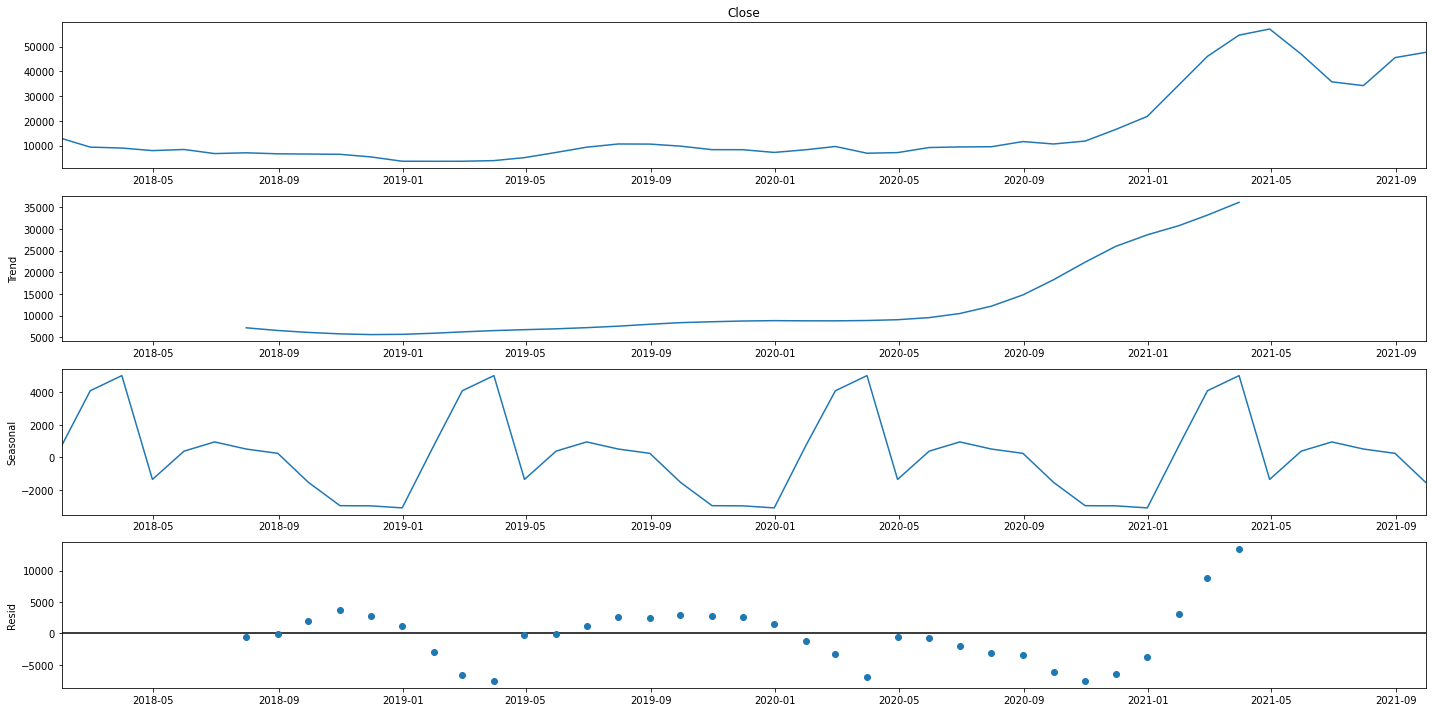

In [8]:
re_btc = btc.Close.resample('M').mean()
rcParams['figure.figsize'] = 20, 10
decomp_series = sm.tsa.seasonal_decompose(re_btc, model='addictive')
decomp_series.plot()
plt.show()

#### Ethereum

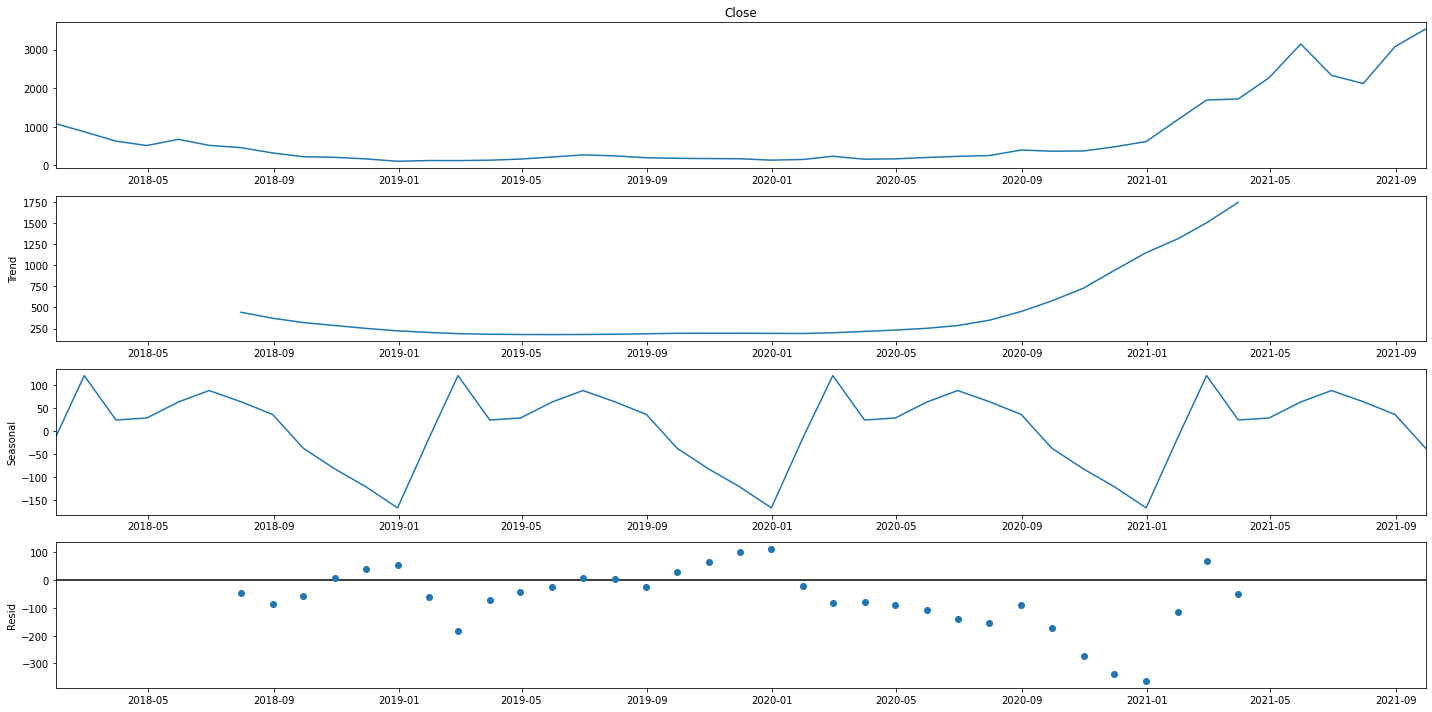

In [9]:
re_eth = eth.Close.resample('M').mean()
rcParams['figure.figsize'] = 20, 10
decomp_series = sm.tsa.seasonal_decompose(re_eth, model='addictive')
decomp_series.plot()
plt.show()

### Stationarity Test

In [10]:
def stationarity_test(col):
    
    print('--------------Stationarity Test--------------')
    adf_result = adfuller(col)
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('No. of lags used:', adf_result[2])
    print('No. of observations used :', adf_result[3])
    if adf_result[1] < 0.05:
        print('TSD is Stationary')
    else:
        print('TSD is not Stationary')
    print( 'Critical Values:' )
    for k, v in adf_result[4].items():
        print( f' {k} : {v} ' )
    print('\n')

# Bitcoin
stationarity_test(re_btc)

# Etheruem
stationarity_test(re_eth)

--------------Stationarity Test--------------
ADF Statistic: -0.445924025748487
p-value: 0.9021441490866006
No. of lags used: 2
No. of observations used : 42
TSD is not Stationary
Critical Values:
 1% : -3.596635636000432 
 5% : -2.933297331821618 
 10% : -2.6049909750566895 


--------------Stationarity Test--------------
ADF Statistic: 1.1173564855126834
p-value: 0.9953620646011996
No. of lags used: 8
No. of observations used : 36
TSD is not Stationary
Critical Values:
 1% : -3.626651907578875 
 5% : -2.9459512825788754 
 10% : -2.6116707716049383 




### Price Change

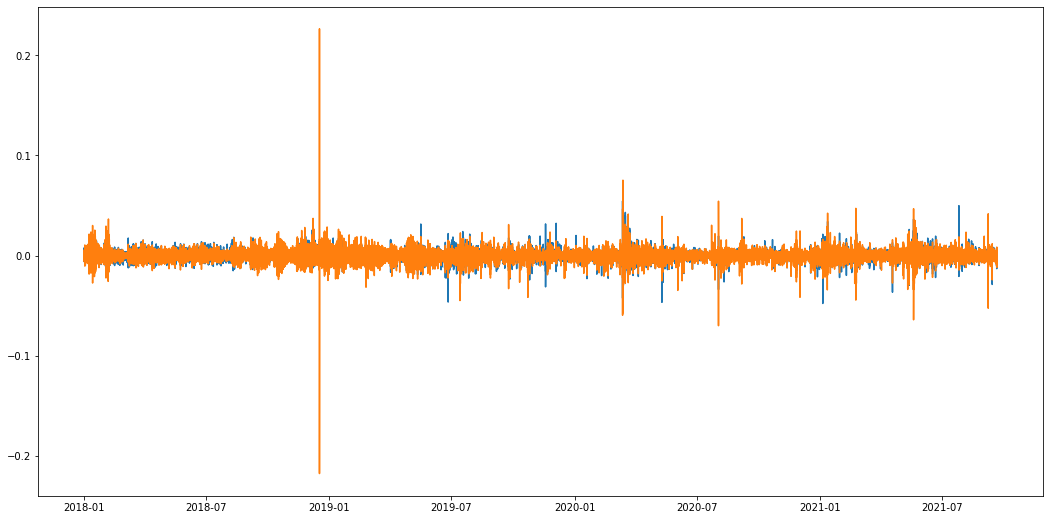

In [11]:
def diff(tsd, periods=1):
    return np.log(tsd).diff(periods=periods)

btc_change = diff(btc.Close)[1:]
eth_change = diff(eth.Close)[1:]
plt.figure(figsize=(18,9))
plt.plot(btc_change);
plt.plot(eth_change);
plt.show()

### Autocorrelation and Partial Autocorrelation

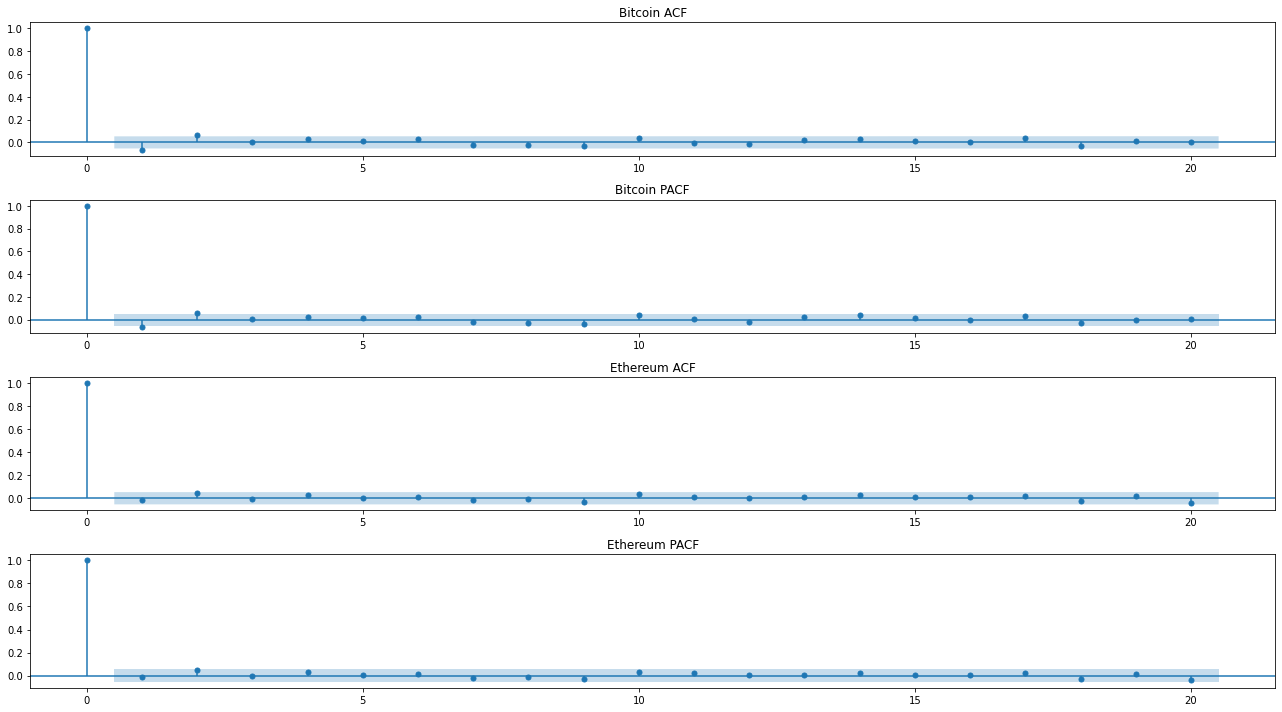

In [12]:
rcParams['figure.figsize'] = 18, 10
re_btc = diff(btc.Close)[1:].resample('D').mean()
re_eth = diff(eth.Close)[1:].resample('D').mean()

fig, axes = plt.subplots(4,1)
fig = plot_acf(re_btc, lags=20, ax=axes[0])
fig = plot_pacf(re_btc, lags=20, ax=axes[1])
fig = plot_acf(re_eth, lags=20, ax=axes[2])
fig = plot_pacf(re_eth, lags=20, ax=axes[3])
axes[0].set_title('Bitcoin ACF')
axes[1].set_title('Bitcoin PACF')
axes[2].set_title('Ethereum ACF')
axes[3].set_title('Ethereum PACF')

plt.tight_layout()
plt.show()

### Checking for correlation between BTC and ETH

#### 2018-2021

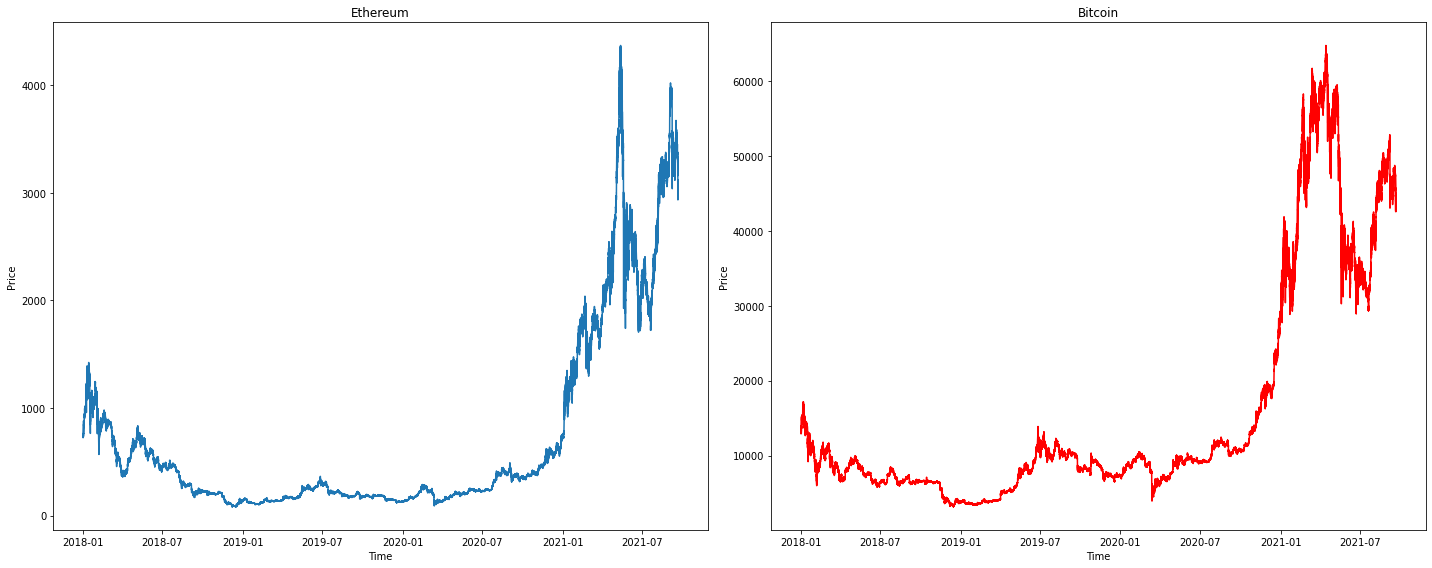

In [13]:
fig = plt.figure(figsize=(20, 8))
fig.add_subplot(121)
plt.title('Ethereum')
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(eth.time, eth.Close)

fig.add_subplot(122)
plt.title('Bitcoin')
plt.plot(btc.time, btc.Close, color='r')
plt.xlabel('Time')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

#### September 2021

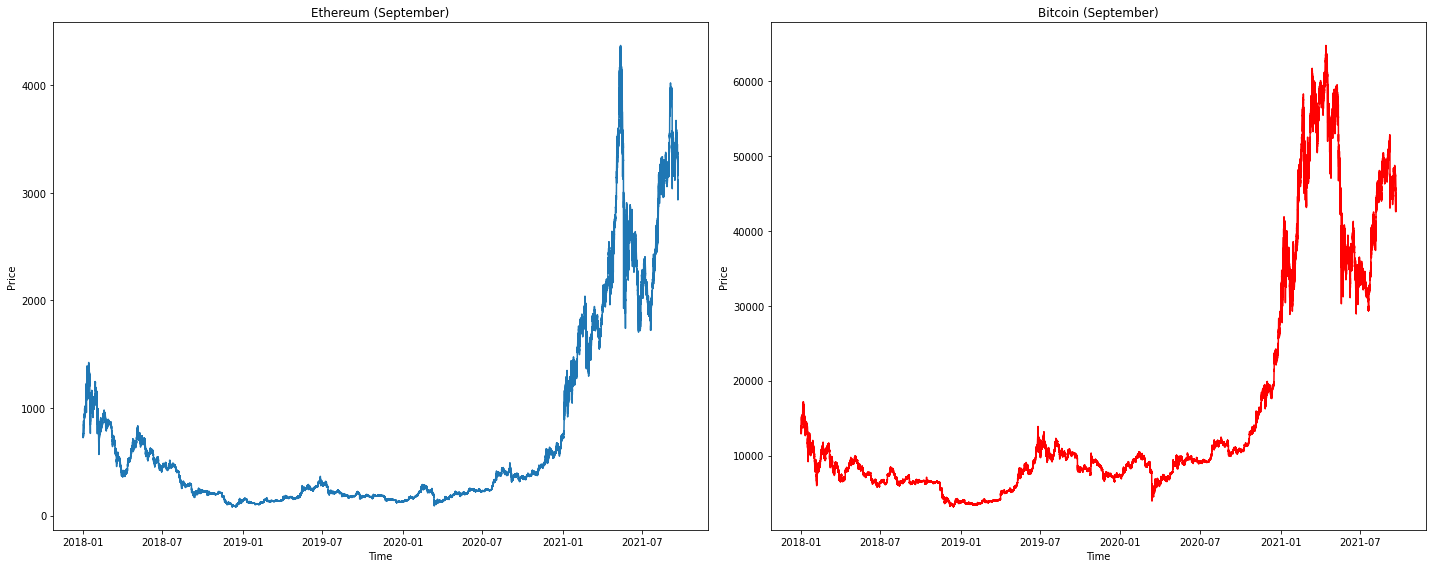

In [14]:
# 1 Month Plot

fig = plt.figure(figsize=(20, 8))
fig.add_subplot(121)
plt.title('Ethereum (September)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(eth.index, eth.Close)

fig.add_subplot(122)
plt.title('Bitcoin (September)')
plt.plot(btc.index, btc.Close, color='r')
plt.xlabel('Time')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

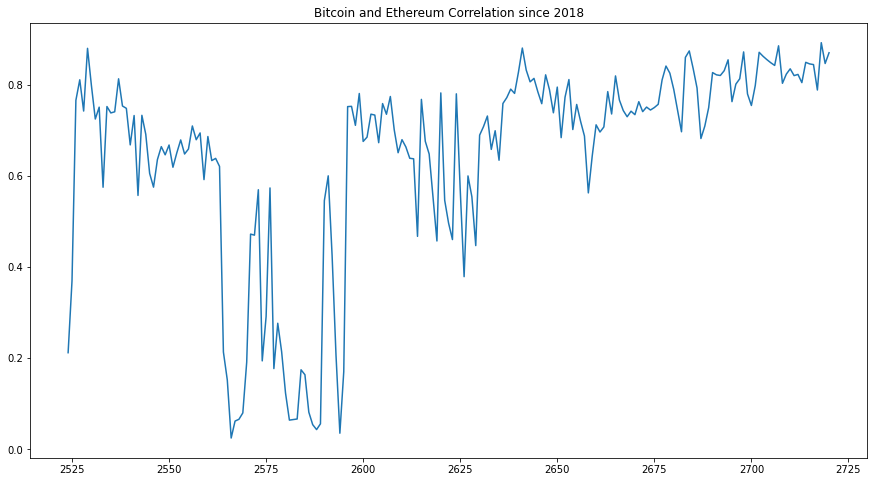

In [15]:
btc_change.rename('Bitcoin', inplace=True)
eth_change.rename('Etheruem', inplace=True)
asset_corr = pd.concat([btc_change, eth_change], axis=1)

to_timestamp = lambda a: [time.mktime(t.timetuple()) for t in a]
asset_corr.index = to_timestamp(asset_corr.index)
corr = asset_corr.groupby(asset_corr.index//(10000*60)).corr().loc[:,"Bitcoin"].loc[:,"Etheruem"]
rcParams['figure.figsize'] = 15, 8
corr.plot()
plt.title('Bitcoin and Ethereum Correlation since 2018')
plt.show()